In [52]:
import os
import glob
import json
import matplotlib.pyplot as plt
import numpy as np

from main import main
from limit_states import REGISTRY as ls_REGISTRY

Define config file

In [ ]:
config = {}
# Config file for the active learning experiment
config = {
    'case_study':'four_branch_6', # 'four_branch_6', 'four_branch_7', 'hat', 'himmelblau', 'nonlinear_oscillator', 'high_dimensional'
    'al_strategy': 'moo', # 'u', 'eff', 'moo'
    'al_batch': 1, # Number of samples to acquired at each AL iteration
    'total_samples': 100, # Total number of training samples
    'passive_samples': 10, # Initial dataset size (LHS)
    'n_mcs_pool': 1000000, # Number of samples in the MCS pool
    'n_mcs_pf': 10000000, # Number of samples for the MCS probability of failure estimate
    'seed': 28,  # Random seed for reproducibility
    'save_interval': 10, # Save the model every n iterations
    'pareto_metrics': True, # If True, save the Pareto front at every AL iteration
}

Config parameters for MOO-based acquisition strategies

In [54]:
# Define the acquisition strategy for MOO-based training
if config['al_strategy'] == 'moo':
    # Multi-objective optimization methods
    config['moo_method'] = 'reliability' # 'knee', 'compromise', 'reliability'

# Add relevant parameters for the MOO-R method
if config['moo_method'] == 'reliability':
    config['N_it'] = 2 # Number of iterations for active learning
    config['delta_p0'] = 0.2 # threshold of relative difference in reliabity estimate at which gamma=0.5
    config['k_balance'] = 40 # Positive constant controlling how quickly gamma transition from 0 to 1

Run active learning loop

In [55]:
name_exp = 'test'
main(config=config, name_exp=name_exp)

Experiment settings: {'case_study': 'four_branch_6', 'al_strategy': 'moo', 'al_batch': 1, 'total_samples': 100, 'passive_samples': 10, 'n_mcs_pool': 1000000, 'n_mcs_pf': 10000000, 'seed': 28, 'save_interval': 10, 'pareto_metrics': True, 'moo_method': 'reliability', 'N_it': 2, 'delta_p0': 0.2, 'k_balance': 40} 

Reference Pf: 4.461E-03 

Training size: 10 samples 

/Users/jonathan/Documents/MOAL/clean/AL_StructuralReliability/main.py:116: RuntimeWarning: invalid value encountered in scalar divide
  b_stab = np.abs(B_model - b_j) / B_model   # relative difference with previous beta


Pf_ref: 4.461E-03, Pf_model: 0.000E+00, B_rel_diff: inf%, B_stab: nan%
delta_pf_avg: 100.000, gamma_log: 1.000 

Training size: 11 samples Pf_ref: 4.461E-03, Pf_model: 1.736E-03, B_rel_diff: 11.76%, B_stab: inf%
delta_pf_avg: 100.000, gamma_log: 1.000 

Training size: 12 samples Pf_ref: 4.461E-03, Pf_model: 7.534E-03, B_rel_diff: -7.05%, B_stab: 20.2%
delta_pf_avg: 51.669, gamma_log: 1.000 

Training size: 13 samples Pf_ref: 4.461E-03, Pf_model: 7.427E-03, B_rel_diff: -6.85%, B_stab: 0.2%
delta_pf_avg: 1.676, gamma_log: 1.000 

Training size: 14 samples Pf_ref: 4.461E-03, Pf_model: 7.201E-03, B_rel_diff: -6.42%, B_stab: 0.5%
delta_pf_avg: 0.022, gamma_log: 0.001 

Training size: 15 samples Pf_ref: 4.461E-03, Pf_model: 5.993E-03, B_rel_diff: -3.92%, B_stab: 2.6%
delta_pf_avg: 0.099, gamma_log: 0.017 

Training size: 16 samples Pf_ref: 4.461E-03, Pf_model: 5.569E-03, B_rel_diff: -2.93%, B_stab: 1.0%
delta_pf_avg: 0.119, gamma_log: 0.038 

Training size: 17 samples Pf_ref: 4.461E-03, Pf_m

Loading results

In [58]:
base = 'results'
# Base results directory
script_folder = os.getcwd() # Current directory 
base_results_dir = os.path.join(
    script_folder,  
    base
)

# Construct the directory pattern based on the configuration
if config['al_strategy'] == 'moo':
    
    dir_pattern = os.path.join(
    base_results_dir, 
    config['case_study'], 
    f"{config['al_strategy']}_{config['moo_method']}_{config['al_batch']}_{name_exp}_*"
)
else:
    dir_pattern = os.path.join(
        base_results_dir, 
        config['case_study'], 
        f"{config['al_strategy']}_{config['al_batch']}_{name_exp}_*"
    )
# Find all directories matching the pattern
matching_dirs = glob.glob(dir_pattern)
output_json_path = os.path.join(matching_dirs[0], 'output.json')

# Load the output.json file if it exists
if os.path.isfile(output_json_path):
    with open(output_json_path, 'r') as f:
        output_data = json.load(f)

Plot Pf evolution

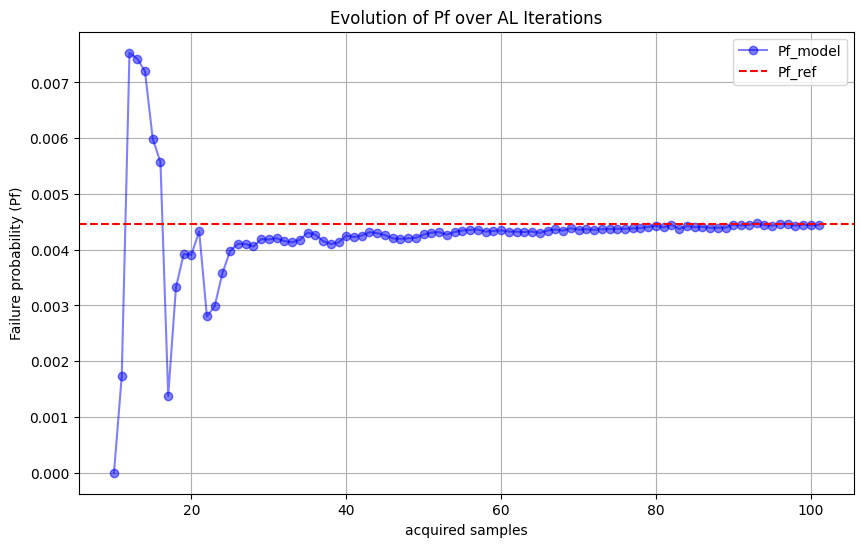

In [59]:
# Loading limit state and ref. Pf
lstate = ls_REGISTRY[config['case_study']]()
Pf_ref = lstate.target_pf

# Extract the Pf_model values
pf_model = output_data['Pf_model']

# Generate the x-axis values starting from config['passive_samples']
iterations = range(config['passive_samples'], config['passive_samples'] + len(pf_model))

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(iterations, pf_model, marker='o', linestyle='-', color='b', label='Pf_model', alpha=0.5)
plt.axhline(y=Pf_ref, color='r', linestyle='--', label='Pf_ref')
plt.xlabel('acquired samples')
plt.ylabel('Failure probability (Pf)')
plt.title('Evolution of Pf over AL Iterations')
plt.legend()
plt.grid(True)
plt.show()

Plot Pareto samples per Al iteration

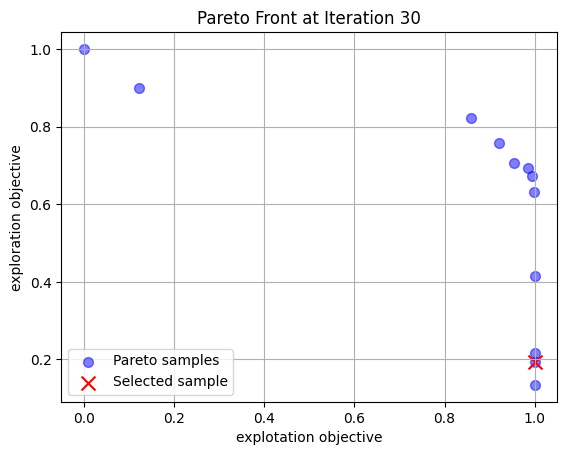

In [69]:
# iteration index for Pareto metrics
i = 30

# Extract the first element of output_data['Pareto_metrics'][i]
first_element = np.array(output_data['Pareto_metrics'][i][0])

# Extract X and Y for the first element
x1 = first_element[:, 0]  # First column
y1 = first_element[:, 1]  # Second column

# Extract the second element of output_data['Pareto_metrics'][i]
second_element = np.array(output_data['Pareto_metrics'][i][1])

# Extract X and Y for the second element
x2 = second_element[0]  # First column
y2 = second_element[1]  # Second column

# Plot the first element
plt.scatter(x1+1, y1, label='Pareto samples', s=50, color='blue', alpha=0.5)

# Plot the second element
plt.scatter(1-x2, y2, label='Selected sample', color='red', marker='x', s=100)

# Add labels, legend, and title
plt.xlabel('explotation objective')
plt.ylabel('exploration objective')
plt.title(f'Pareto Front at Iteration {i}')
plt.grid(True)
plt.legend(loc='lower left')

# Show the plot
plt.show()